Library

In [1]:
import segmentation_models_pytorch as smp
import torch
import logging
import os
import datetime
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from sklearn.model_selection import KFold
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader
import math

from sklearn.model_selection import train_test_split

from torch.cuda.amp import GradScaler, autocast
import time

from tqdm import tqdm
from glob import glob

util

In [2]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def get_today():
    today = datetime.datetime.today()
    return today.strftime("%Y%m%d")

Preprocessing

In [3]:
img1 = cv2.imread('./train/lr/TRAIN_00000.jpg')
img2 = cv2.imread('./train/hr/TRAIN_00000.png')

print(f'저해상도 이미지: {img1.shape[0]}, {img1.shape[1]}')
print(f'고해상도 이미지: {img2.shape[0]}, {img2.shape[1]}')

저해상도 이미지: 64, 64
고해상도 이미지: 256, 256


In [3]:
patch_size = 96

def cut_img(path, lr = True):
    stride = int(patch_size / 2)
    num = 0
    img = cv2.imread(path)[..., ::-1]
    if lr == True:
        img = cv2.resize(img, None, fx=4.0, fy=4.0)
    
    for top in range(0, img.shape[0], stride):
        for left in range(0, img.shape[1], stride):
            name = path.split('/')[-1].split('.')[0]
            piece_img = np.zeros([patch_size, patch_size, 3], np.uint8)
            temp_img = img[top: top + patch_size, left: left + patch_size, :]
            piece_img[:temp_img.shape[0], :temp_img.shape[1], :] = temp_img
            
            if lr == True:
                os.makedirs('./datasets/lr', exist_ok=True)
                img_name = name + '_{}'.format(num)
                np.save('./datasets/{}.npy'.format(img_name), piece_img)
            else:
                os.makedirs('./datasets/hr', exist_ok=True)
                img_name = name + '_{}'.format(num)
                np.save('./datasets/{}.npy'.format(img_name), piece_img)                
            
            num += 1
            
def process_all_images_in_directory(directory_path, lr=True):
    file_extensions = ['*.png', '*.jpg']
    file_paths = []
    
    for extension in file_extensions:
        file_paths.extend(glob(os.path.join(directory_path, extension)))
    
    for file_path in tqdm(file_paths):
        cut_img(file_path, lr)


In [4]:
lr_path = './train/lr/'
hr_path = './train/hr/'

process_all_images_in_directory(lr_path, lr=True)
process_all_images_in_directory(hr_path, lr=False)

100%|█████████████████████████████████████████████████████| 15834/15834 [04:22<00:00, 60.23it/s]


Custom Dataset

In [3]:
patch_size = 96

def pad_image(image, target_size):
    height, width, _ = image.shape
    pad_height = max(0, target_size[0] - height)
    pad_width = max(0, target_size[1] - width)
    
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), 
                          mode='constant', constant_values=0)
    return padded_image / 255.0

# def pad_to_multiple_of_32(img):
#     h, w, c = img.shape
#     new_h = (h + 31) // 32 * 32
#     new_w = (w + 31) // 32 * 32
#     pad_h = new_h - h
#     pad_w = new_w - w
#     padded_img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)
#     return padded_img

class PatchDataset(Dataset):
    def __init__(self, lr_paths, hr_paths, transform=None, 
                 target_size=(patch_size, patch_size)):
        self.lr_paths = lr_paths
        self.hr_paths = hr_paths
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr_path = self.lr_paths[idx]
        hr_path = self.hr_paths[idx]
        
        lr_patch = np.load(lr_path)
        hr_patch = np.load(hr_path)
        
        if np.isnan(lr_patch).any() or np.isnan(hr_patch).any():
            raise ValueError("Data contains nan values")

        lr_patch = pad_image(lr_patch, self.target_size)
        hr_patch = pad_image(hr_patch, self.target_size)
        
        if self.transform:
            lr_patch = self.transform(lr_patch)
            hr_patch = self.transform(hr_patch)
        lr_patch = lr_patch.transpose(2, 0, 1).astype('float32')
        hr_patch = hr_patch.transpose(2, 0, 1).astype('float32')
        
#         return lr_patch, hr_patch
        return {'lr_image': lr_patch, 'hr_image': hr_patch}


lr_path_ = np.array(sorted(glob('./datasets/lr/*')))
hr_path_ = np.array(sorted(glob('./datasets/hr/*')))

lr_path_train, lr_path_val, hr_path_train, hr_path_val = train_test_split(
    lr_path_, hr_path_, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = PatchDataset(lr_path_train, hr_path_train, transform = None)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = PatchDataset(lr_path_val, hr_path_val, transform = None)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true - pred) ** 2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20 * np.log10(pixel_max / rmse_score(true, pred))
    return score

def evaluate(model, val_loader, device):
    model.eval()
    psnr_total = []
    with torch.no_grad():
        for batch in val_loader:
            lr_img = batch['lr_image'].float().to(device)
            hr_img = batch['hr_image'].float().to(device)

            pred_hr_img = model(lr_img).cpu().numpy().transpose(0, 2, 3, 1)
            hr_img = hr_img.cpu().numpy().transpose(0, 2, 3, 1)
            
            if np.isnan(pred_hr_img).any():
                raise ValueError("Model output contains nan values")

            for i in range(pred_hr_img.shape[0]):
                psnr = psnr_score(hr_img[i] * 255, pred_hr_img[i] * 255, 255)
                psnr_total.append(psnr)

    psnr_mean = np.mean(psnr_total)
    return psnr_mean

def train(model, optimizer, train_loader, val_loader, scheduler, device, num_epochs):
    model.to(device)
#     criterion = nn.MSELoss().to(device)
    criterion = nn.L1Loss().to(device)  # 변경된 L1 손실 함수
    scaler = GradScaler()
    best_model = None
    best_loss = float('inf')
    best_psnr = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = []
        for batch in tqdm(train_loader):
            lr_img = batch['lr_image'].float().to(device) # real_a
            hr_img = batch['hr_image'].float().to(device) # real_b

            optimizer.zero_grad()

#             pred_hr_img = model(lr_img)
#             loss = criterion(pred_hr_img, hr_img)

#             loss.backward()
#             optimizer.step()

#             train_loss.append(loss.item())
            
            with autocast():
                pred_hr_img = model(lr_img) # fake_b
                loss = criterion(pred_hr_img + lr_img, hr_img)

            if torch.isnan(loss).any():
                raise ValueError("Loss contains nan values")

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss.append(loss.item())

            time.sleep(0.2)

        if scheduler is not None:
            scheduler.step()

        _train_loss = np.mean(train_loss)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}]')

        # Validate the model on the validation set
        psnr_mean = evaluate(model, val_loader, device)
        print(f'Epoch : [{epoch}] Validation PSNR : [{psnr_mean:.2f}]')

        # Save the best model based on PSNR
        if psnr_mean > best_psnr:
            best_psnr = psnr_mean
            best_model = model.state_dict()

    # Save the best model
    torch.save(best_model, 'best_model.pth')
    print(f'Best PSNR: {best_psnr:.2f}')
    
    return best_model

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = smp.UnetPlusPlus(encoder_name="efficientnet-b7", 
                         encoder_weights='imagenet', 
                         in_channels=3, 
                         classes=3).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# 학습 수행
best_model = train(model, optimizer, train_dataloader, test_dataloader, scheduler, device, num_epochs=3)
torch.save(best_model, "best_model_b7_3.pth")

100%|████████████████████████████████████████████| 7126/7126 [1:06:04<00:00,  1.80it/s]


Epoch : [1] Train Loss : [0.03871]
Epoch : [1] Validation PSNR : [9.37]


100%|████████████████████████████████████████████| 7126/7126 [1:18:20<00:00,  1.52it/s]


Epoch : [2] Train Loss : [0.02352]
Epoch : [2] Validation PSNR : [9.39]


100%|████████████████████████████████████████████| 7126/7126 [1:29:38<00:00,  1.32it/s]


Epoch : [3] Train Loss : [0.02268]
Epoch : [3] Validation PSNR : [9.39]
Best PSNR: 9.39


In [12]:
patch_size = 96
stride = int(patch_size / 2)
batch_size = 1

test_path = sorted(glob('./output_test/*'))
# total = np.zeros(shape=(5, 18, patch_size, patch_size, 3))
total = np.zeros(shape=(len(test_path), 256, 256, 3))
    
model = smp.UnetPlusPlus(encoder_name="efficientnet-b7", 
                         encoder_weights=None, 
                         in_channels=3, 
                         classes=3).to(device)

model.load_state_dict(torch.load("best_model_b7_3.pth"))

model.eval()

# for j, lr_path in tqdm(enumerate(test_path)):
for j, lr_path in tqdm(enumerate(test_path), total=len(test_path), leave=True):
    img = cv2.imread(lr_path)[..., ::-1]
    img = cv2.resize(img, (256, 256))
    img = (img / 255)

    crop = []
    position = []
    batch_count = 0

    result_img = np.zeros(shape=(img.shape[0], img.shape[1], 3))
    voting_mask = np.zeros(shape=(img.shape[0], img.shape[1], 3))

    for top in range(0, img.shape[0], stride):
        for left in range(0, img.shape[1], stride):
            piece = np.ones([patch_size, patch_size, 3], np.float32)
            temp = img[top: top + patch_size, left: left + patch_size, :]
            piece[:temp.shape[0], :temp.shape[1], :] = temp
            crop.append(piece)
            position.append([top, left])
            batch_count += 1
            if batch_count == batch_size:
                input_ = np.array(crop)
                input_ = torch.from_numpy(input_.transpose(0, 3, 1, 2)).to(device)

                with torch.no_grad():
                    pred = model(input_)

                pred = (pred + input_)
                pred = pred.cpu().detach().numpy().transpose(0, 2, 3, 1).astype('float')

                for num, (top, left) in enumerate(position):
                    piece = pred[num]
                    piece = np.clip(piece, 0, 1)

                    h, w, c = result_img[top:top + patch_size, left:left + patch_size].shape
                    result_img[top:top + patch_size, left:left + patch_size] += piece[:h, :w]
                    voting_mask[top:top + patch_size, left:left + patch_size] += 1

                batch_count = 0
                crop = []
                position = []


    image_file = result_img / voting_mask

#     total[j // 18, j % 18, :, :, :] = image_file  # 적절한 위치에 이미지 저장
    total[j, :, :, :] = image_file  # 적절한 위치에 이미지 저장
#     psnr = psnr_score((image_file * 255).astype('float'),
#                       gt.astype('float'), 255)    
#     psnr_total.append([psnr])
    
# psnr_mean = np.array(psnr_total).mean()
# print(f"psnr_mean: {psnr_mean}")

100%|████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.52it/s]


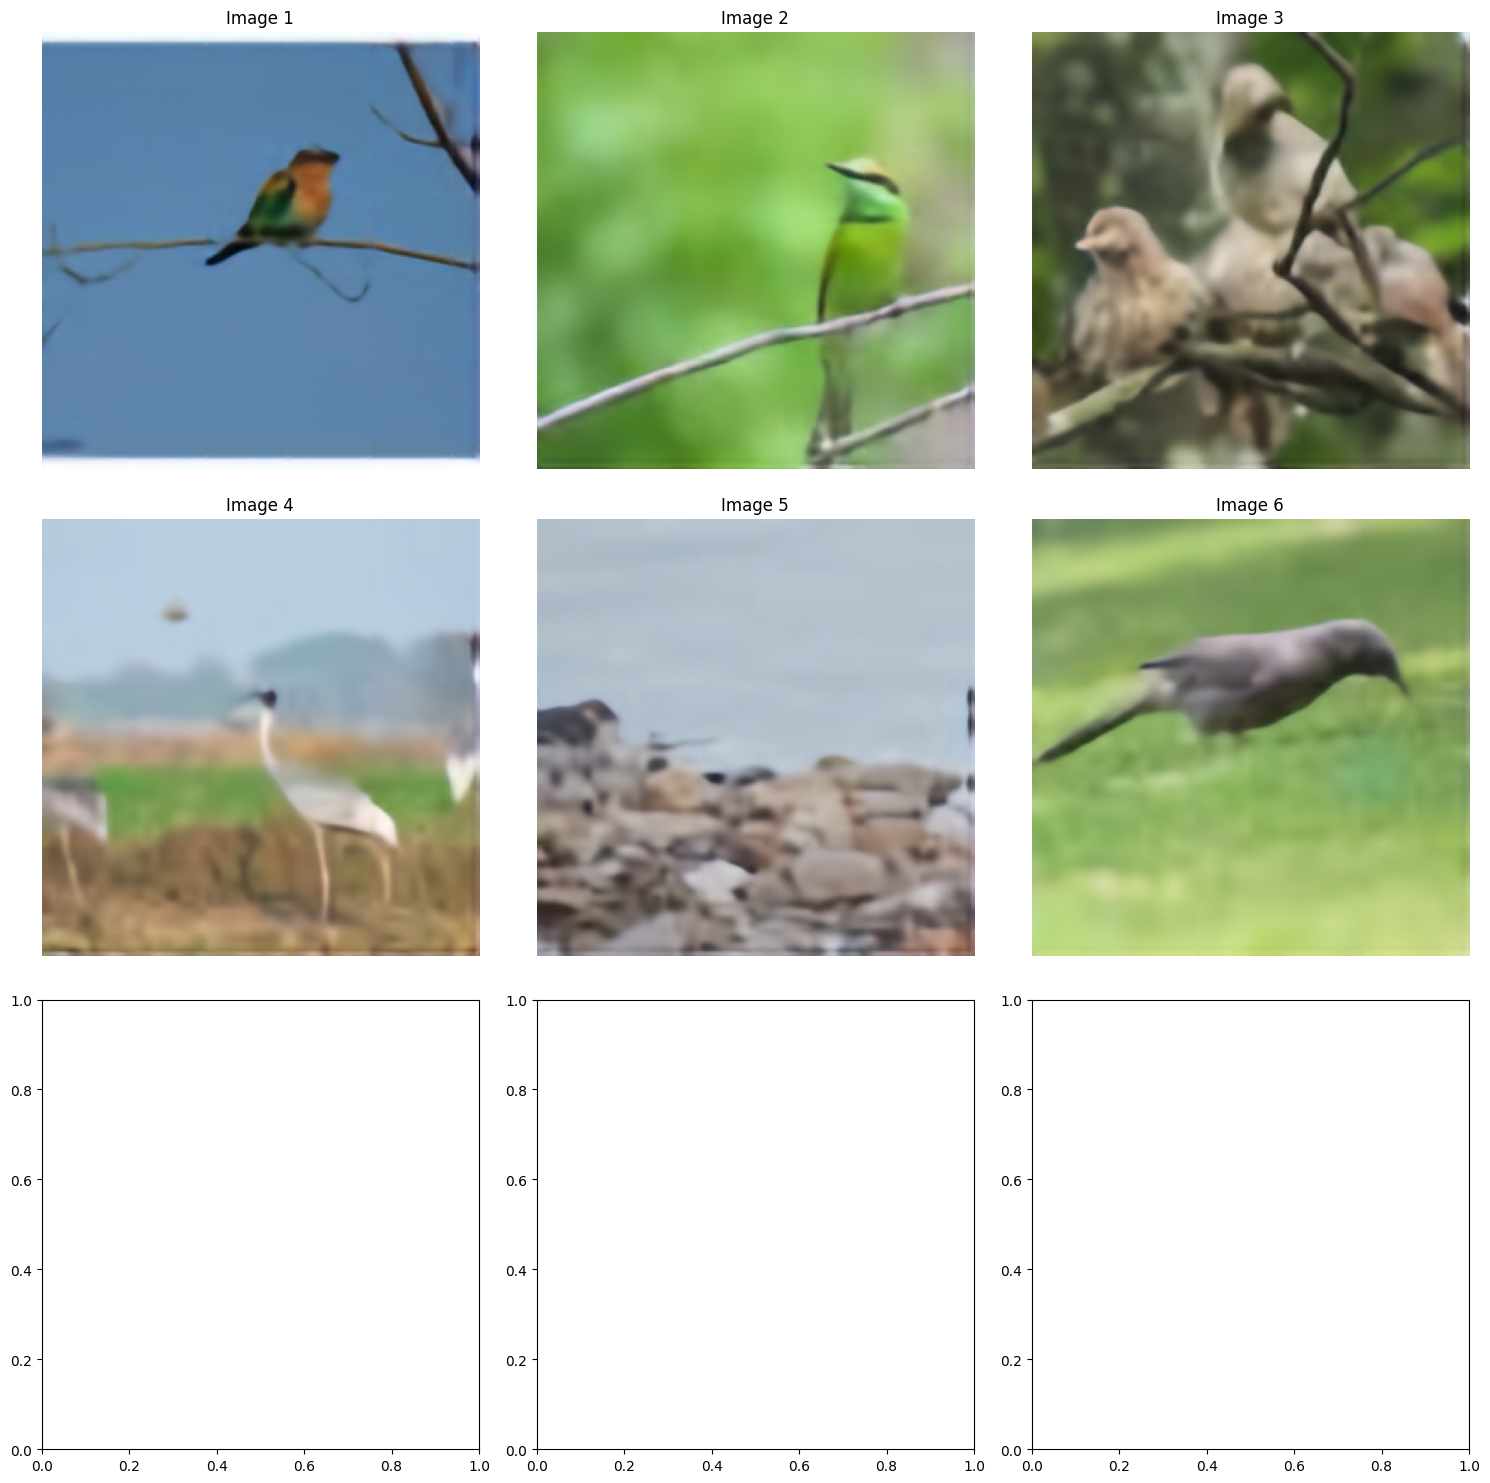

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(test_path) // 3 + 1, 3, figsize=(15, 5 * (len(test_path) // 3 + 1)))
axs = axs.ravel()

for i in range(len(test_path)):
    axs[i].imshow(np.clip(total[i], 0, 1))  # total[i]로 수정하여 모든 이미지를 처리
    axs[i].set_title(f'Image {i + 1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
output_dir = './output_images'
os.makedirs(output_dir, exist_ok=True)

for i in range(len(test_path)):
    # 이미지 시각화
    axs[i].imshow(np.clip(total[i], 0, 1))  # 모든 이미지를 처리하도록 수정
    axs[i].set_title(f'Image {i + 1}')
    axs[i].axis('off')

    # 이미지 파일로 저장
    output_path = os.path.join(output_dir, f'image_{i + 1}.png')
    rgb_image = cv2.cvtColor((total[i] * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, rgb_image)

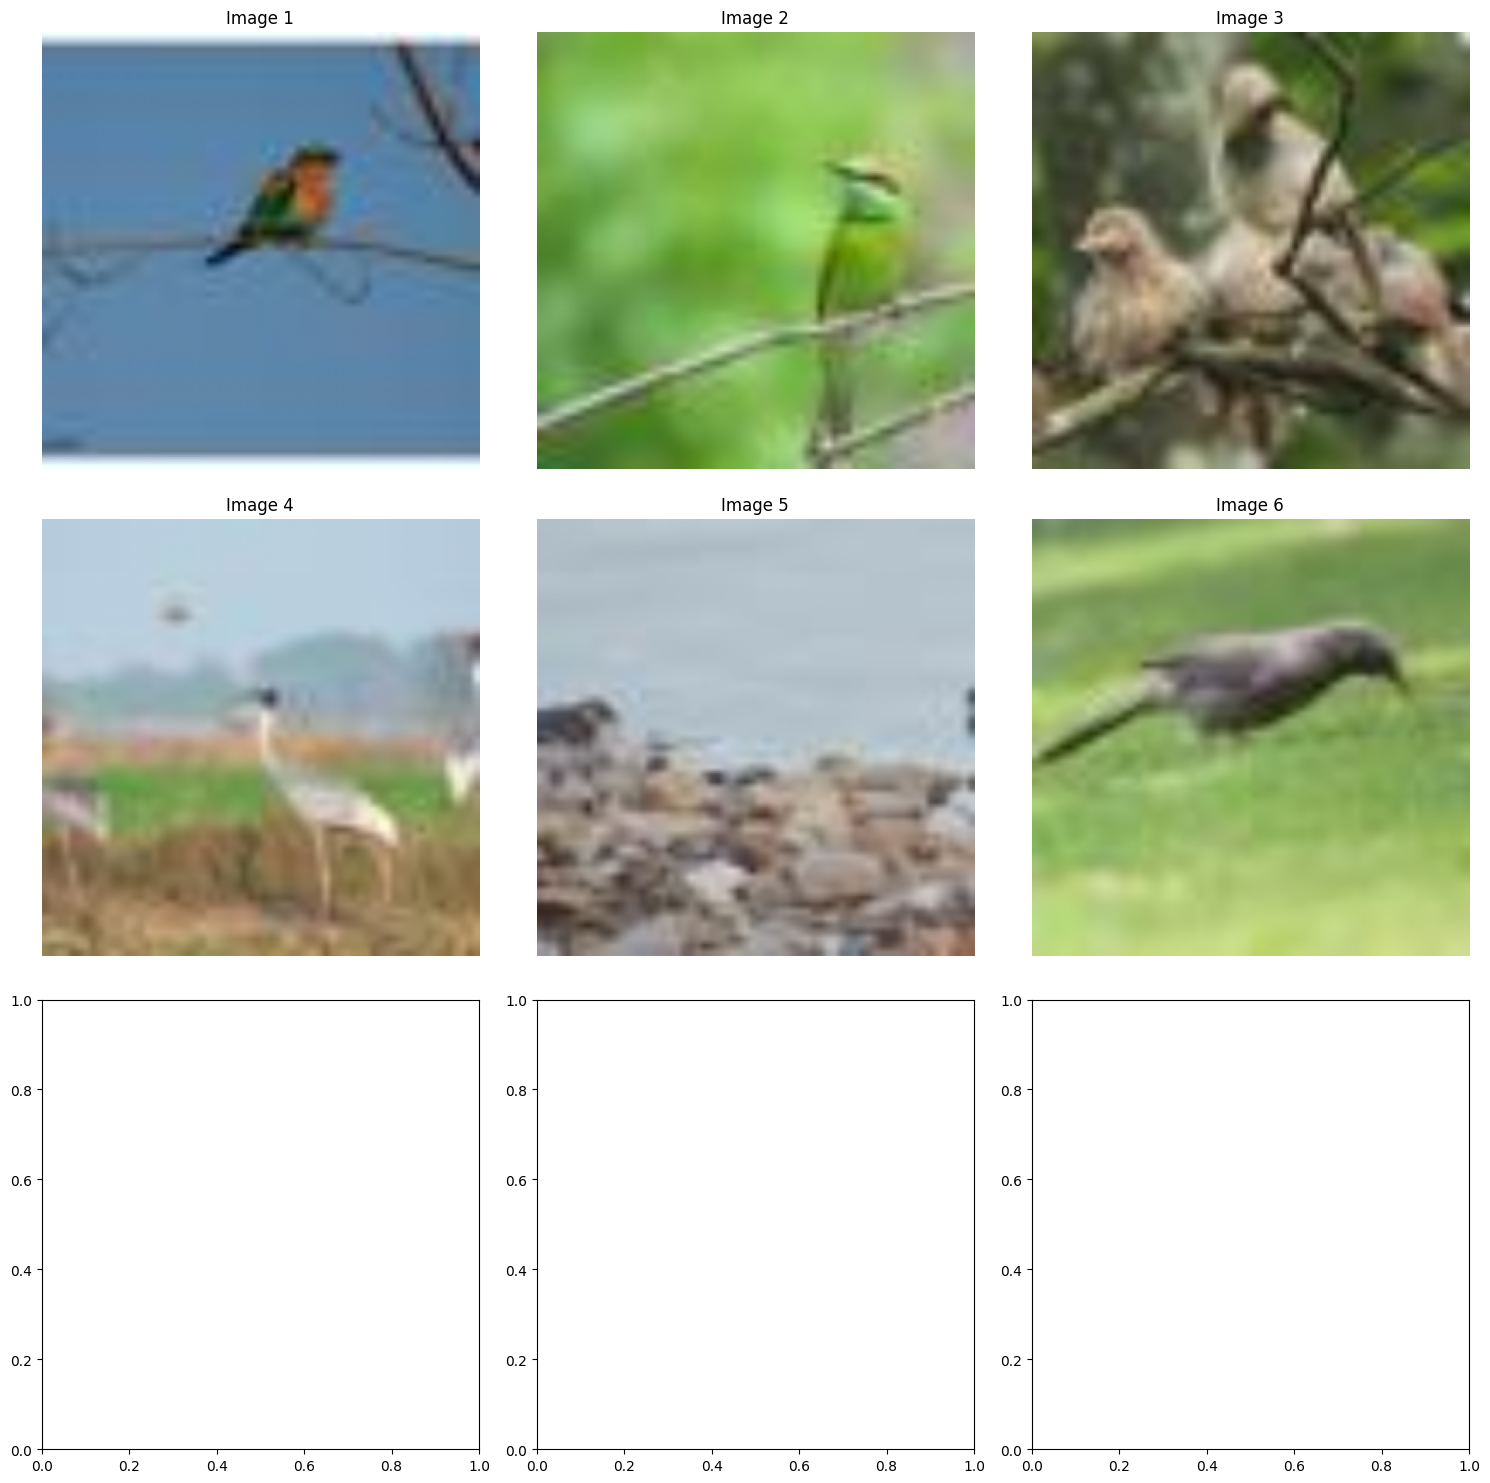

In [22]:
compare_dir = './compare_img'
os.makedirs(compare_dir, exist_ok=True)

# 결과를 저장할 배열
total = np.zeros(shape=(len(test_path), 256, 256, 3))  # 256x256 크기의 이미지를 저장할 배열

for j, lr_path in enumerate(test_path):
    img = cv2.imread(lr_path)[..., ::-1]  # BGR에서 RGB로 변환
    img = cv2.resize(img, (256, 256))  # 256x256으로 확대
    total[j, :, :, :] = img / 255.0  # 이미지를 정규화하여 total 배열에 저장

    # 확대된 이미지를 compare_img 폴더에 저장
    compare_path = os.path.join(compare_dir, f'image_{j + 1}.png')
    cv2.imwrite(compare_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # RGB에서 BGR로 변환하여 저장

# 이미지 출력
fig, axs = plt.subplots(len(test_path) // 3 + 1, 3, figsize=(15, 5 * (len(test_path) // 3 + 1)))
axs = axs.ravel()

for i in range(len(test_path)):
    # 이미지 시각화
    axs[i].imshow(np.clip(total[i], 0, 1))  # 모든 이미지를 처리하도록 수정
    axs[i].set_title(f'Image {i + 1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()